# Methods example
This notebook demonstrates how to simulate attributed graphs, generate node attributes (functional data and histograms), compute structural and attribute distance matrices, and run several clustering methods (k-Fréchet means, kernel k-means, Semi-Relaxed GW and Semi-Relaxed FGW).

- Simulation: generate synthetic graphs and attributes
- Distances: compute structural and attribute distances, combine and visualize them
- Clustering: run Frechet k-means, Kernel k-means, SRGW and SRFGW

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

## Simulation

### Graph generation

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



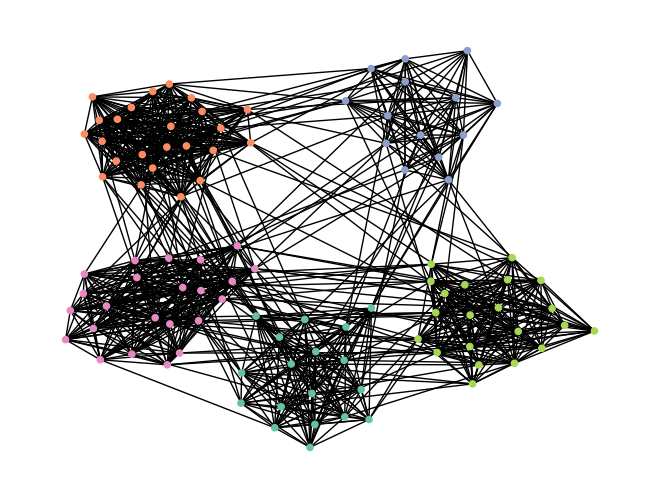

In [2]:
from src.simulation.graph import SimulatedGraph
from src.simulation.utils import ct_group 

n = 100
k = 5
groups = ct_group(n, k)
# groups = np.array([20,20,20,20,20])

graph0 = SimulatedGraph(groups, structure_strength=1)
graph0.plot()

### Graph structure illustration

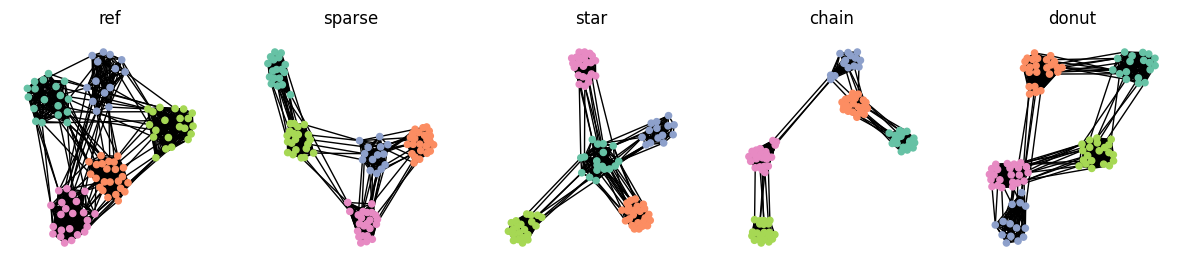

In [3]:
type_graph_list = ['ref','sparse','star','chain','donut']

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
axes = axes.flatten()
for i, type_graph in enumerate(type_graph_list):
    graph = SimulatedGraph(groups, type_graph=type_graph)
    graph.plot(ax = axes[i])
    axes[i].set_title(type_graph)

### Structure strength illustration

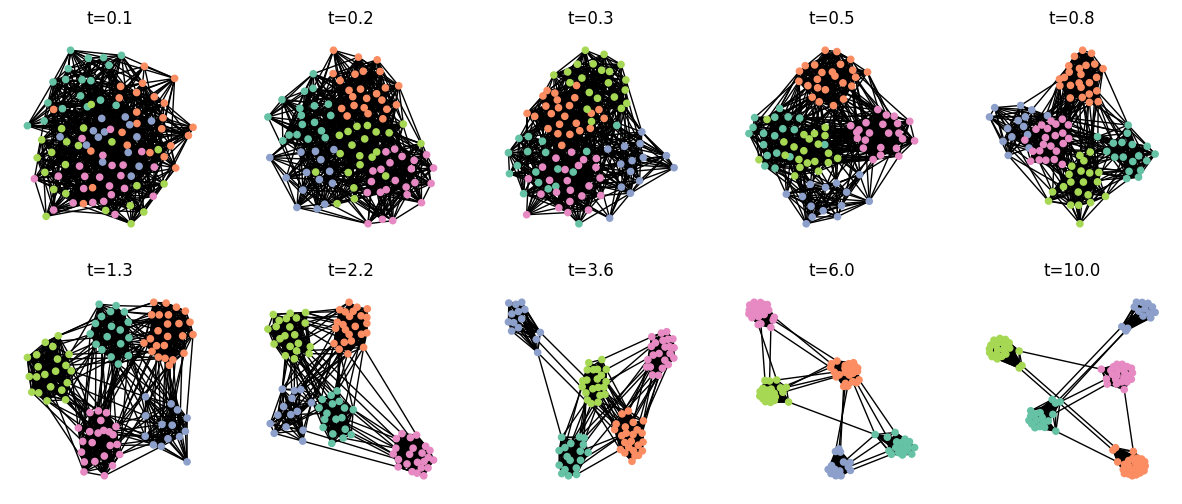

In [4]:
structure_list = np.geomspace(0.1, 10, num=10).round(1)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i, structure_strength in enumerate(structure_list):
    graph = SimulatedGraph(groups, 
                           structure_strength = structure_strength)
    graph.plot(ax = axes[i])
    axes[i].set_title(f"t={structure_strength}")

### Attributes generation

In [5]:
from src.simulation.attributes import SimulatedFunctionalData
functional_data = SimulatedFunctionalData(groups, epsilon=0.1).functions_array
functional_data_noisy = SimulatedFunctionalData(groups, epsilon=5).functions_array

### Attributes + Graph generation

In [6]:
from src.simulation.graph import SimulatedAttributedGraph
from src.distances import combine_alpha

att_graph = SimulatedAttributedGraph(k, groups)

# Get distance matrix for a certain structure force + type of graph
structural_distance_matrix, _ = att_graph.test_structure_force(structure_force=[10], type_graph="chain")
structural_distance_matrix = structural_distance_matrix[0]

# Get attributes distance matrix for a define perturbation
attributes_distance_matrix, distances_hist, distances_fun, _, _ = att_graph.test_c_epsilon(c_list=[1000], epsilon_list=[0.1], product=False)
attributes_distance_matrix = attributes_distance_matrix[0]

# Combine
total_distance_matrix = combine_alpha(structural_distance_matrix, attributes_distance_matrix, alpha=0.5)

Text(0.5, 1.0, 'Combined Distance Matrix')

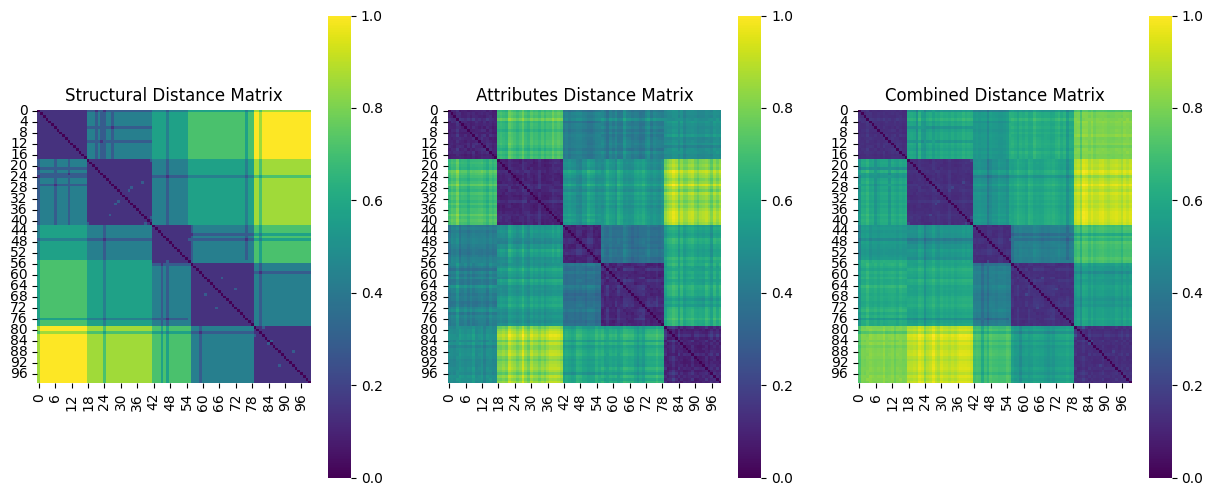

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
sns.heatmap(structural_distance_matrix, cmap = 'viridis', square=True, ax=axes[0])
axes[0].set_title('Structural Distance Matrix')
sns.heatmap(attributes_distance_matrix, cmap = 'viridis', square=True, ax=axes[1])
axes[1].set_title('Attributes Distance Matrix')
sns.heatmap(total_distance_matrix, cmap = 'viridis', square=True, ax=axes[2])
axes[2].set_title('Combined Distance Matrix')

## Clustering

In [8]:
from sklearn.metrics import adjusted_rand_score #ARI
true_labels = att_graph.get_true_labels()

### Initialization

In [9]:
from src.clustering.init_strategies import ClusteringInit

init = ClusteringInit(n, k, total_distance_matrix)
random_init_centroids, random_init_OT = init.random_init()
kpp_init_centroids, kpp_init_OT = init.kmeanspp_init()
embedded_kpp_init_centroids, embedded_kpp_init_OT = init.embedded_kmeanspp_init()

### $k$-Fréchet Means

In [10]:
from src.clustering.kmeans import FrechetKMeans

k_frechet = FrechetKMeans(k=k, centroids_init=embedded_kpp_init_centroids)
k_frechet_labels = k_frechet.partitioning(structural_distance_matrix, attributes_distance_matrix, alpha=0.5)['labels']
print(f'KFréchet Means ARI: {adjusted_rand_score(true_labels, k_frechet_labels)}')

KFréchet Means ARI: 1.0


### Embedded $k$-means

In [11]:
from src.clustering.kmeans import EmbeddedKMeans
k_embedded = EmbeddedKMeans(k=k,
                        centroids_init=embedded_kpp_init_centroids)
k_embedded_labels = k_embedded.partitioning(structural_distance_matrix, attributes_distance_matrix, alpha=0.5)['labels']

print(f'Embedded KMeans ARI: {adjusted_rand_score(true_labels, k_embedded_labels)}')

Embedded KMeans ARI: 1.0


### Semi-relaxed Gromov-Wasserstein

In [12]:
from src.clustering.gw_clustering import SemiRelaxedGWClustering

# equidistante nodes (mean) : value creates the matrix with 0 on diagonal and value elsewhere. Default is 1
srgw = SemiRelaxedGWClustering(n=n, k=k, g0=embedded_kpp_init_OT, value=np.mean(total_distance_matrix))
srgw_labels = srgw.partitioning(structural_distance_matrix, attributes_distance_matrix, alpha=0.5)['labels']

print(f'SRGW ARI: {adjusted_rand_score(true_labels, srgw_labels)}')

SRGW ARI: 1.0


In [13]:
# Embedded version
embedded_srgw = SemiRelaxedGWClustering(n=n, k=k, g0=embedded_kpp_init_OT, value=np.mean(total_distance_matrix))
embedded_srgw_labels = embedded_srgw.partitioning(structural_distance_matrix, 
                                                  attributes_distance_matrix, 
                                                  alpha=0.5, 
                                                  embedded=True)['labels']

print(f'Embedded SRGW ARI: {adjusted_rand_score(true_labels, embedded_srgw_labels)}')

Embedded SRGW ARI: 1.0


### Semi-relaxed Fused Gromov-Wasserstein

In [14]:
from src.clustering.gw_clustering import SemiRelaxedFGWClustering
from src.clustering.utils import transport_plan_to_labels

init_structure = ClusteringInit(n, k, structural_distance_matrix)
_, structural_init_OT = init_structure.embedded_kmeanspp_init()
init_attributes = ClusteringInit(n, k, attributes_distance_matrix)
_, attributes_init_OT = init_attributes.embedded_kmeanspp_init()

distance_attributes_dict = {"hist": distances_hist[0], "fun": distances_fun[0]}
srfgw = SemiRelaxedFGWClustering(n=n, k=k, g0=structural_init_OT, g0_attributes=attributes_init_OT)
srfgw.define_method(weights={"hist":0.5, "fun":0.5},
                    powers={"hist":2, "fun":2},
                    alpha=0.5)
srfgw_results = srfgw.iterate(structural_distance_matrix, 
                              distance_attributes_dict, 
                              value=np.mean(structural_distance_matrix),
                              medoid=True)['ot'][-1]
srfgw_labels = transport_plan_to_labels(srfgw_results)

print(f'Fused ARI: {adjusted_rand_score(true_labels, srfgw_labels)}')

Fused ARI: 1.0
